In [58]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate

In [30]:
SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")

def generate_1d_tfim_circuit(numb_qubits, numb_trotter_steps, rx_angle, num_cl_bits=0, trotter_barriers=False, layer_barriers=False):
    if num_cl_bits==0:
        qc = QuantumCircuit(numb_qubits)
    else:
        qc = QuantumCircuit(numb_qubits, num_cl_bits)
        
    
    for trotter_step in range(numb_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
    
    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_bariers=False):
    for i in range(0, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_bariers:
        qc.barrier()
        
    for i in range(1, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_bariers:
        qc.barrier()
        
    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_bariers:
        qc.barrier()

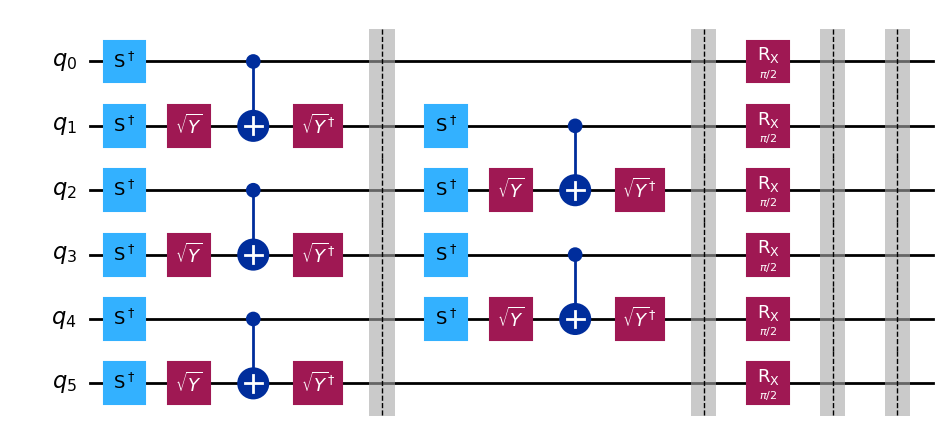

In [31]:
numb_qubits = 6
numb_trotter_steps = 1
rx_angle = 0.5*np.pi

qc = generate_1d_tfim_circuit(numb_qubits, numb_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=-1)

In [32]:
def append_mirrored_1d_tfim_circuit(qc, numb_qubits, numb_trotter_steps, rx_angle, trotter_barriers=False, layer_barriers=False):

    for trotter_step in range(numb_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_bariers=False):
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_bariers:
        qc.barrier()
        
    for i in range(1, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_bariers:
        qc.barrier()
        
    for i in range(0, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_bariers:
        qc.barrier()

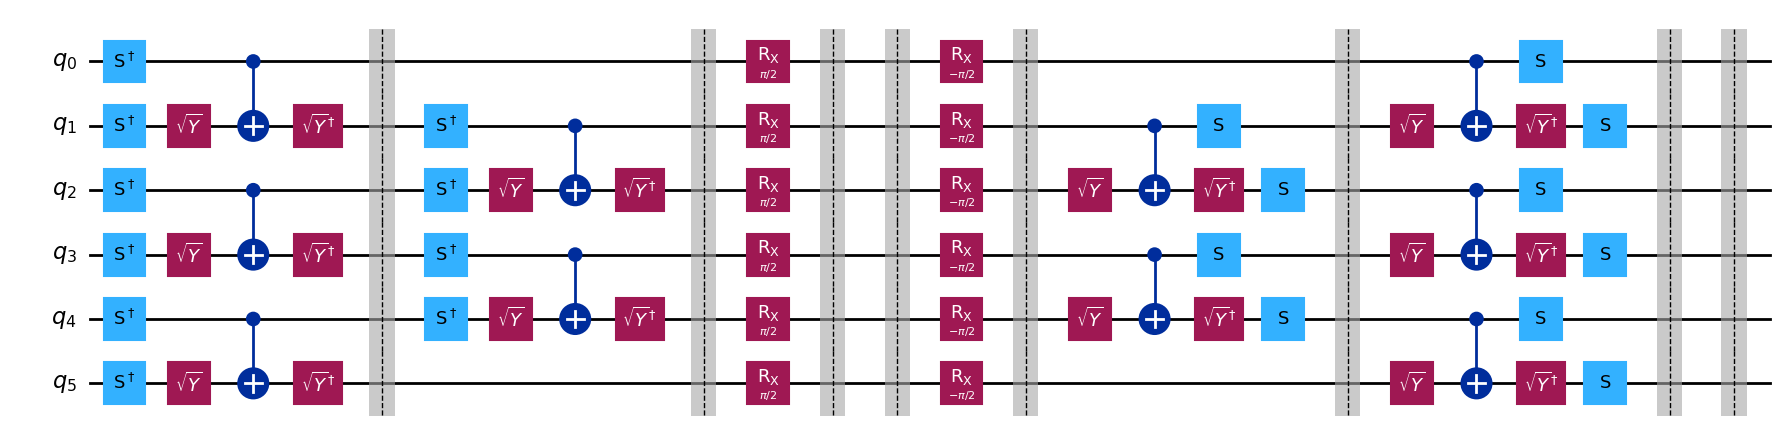

In [33]:
append_mirrored_1d_tfim_circuit(qc, numb_qubits, numb_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=-1)

### Define The Problem

In [36]:
max_trotter_steps = 10
num_of_qubits = 100
measured_qubits = [49, 50]

qc_list = []
for trotter_step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_of_qubits, numb_trotter_steps, rx_angle, num_cl_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
    append_mirrored_1d_tfim_circuit(qc, num_of_qubits, numb_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

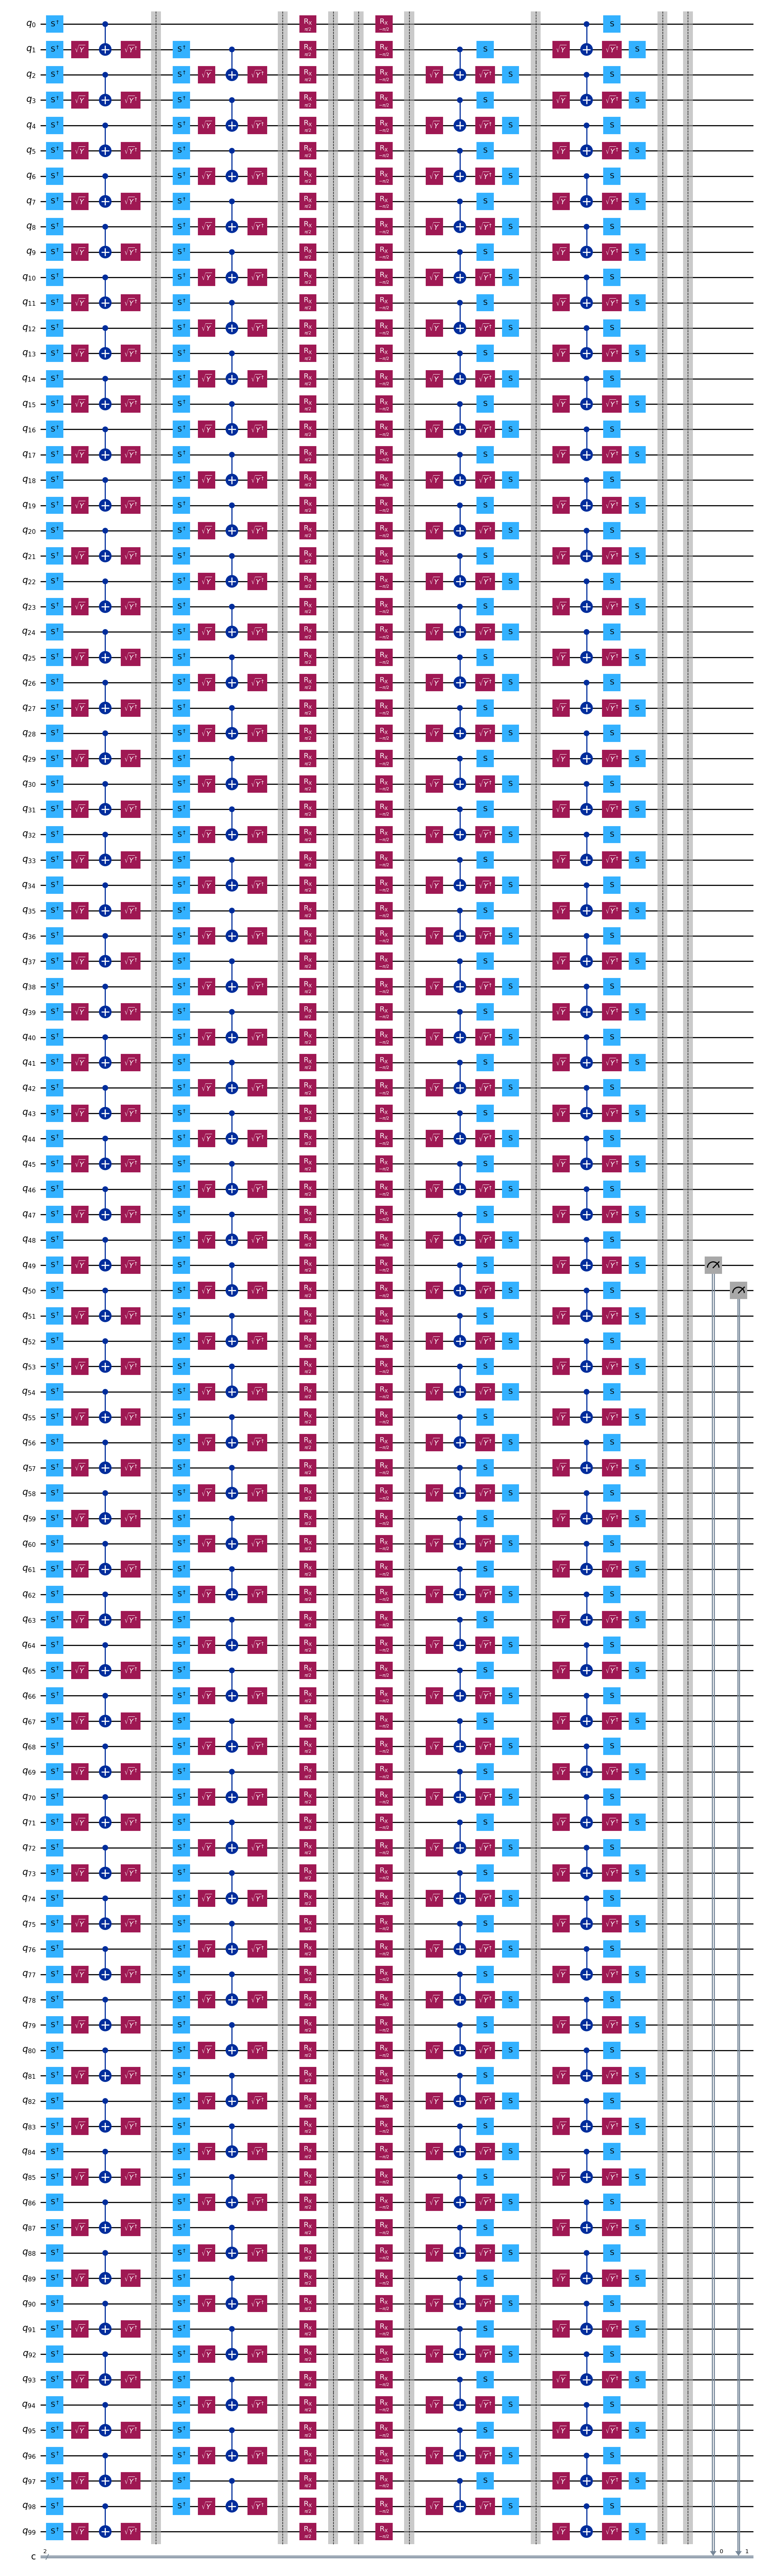

In [37]:
qc_list[1].draw(output='mpl', fold=-1)

In [39]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.backend(backend_name)

qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = 'XY4'

job = sampler.run(qc_transpiled_list)
print(job.job_id())

cxs9dy73wrp0008kq2q0


In [48]:
job = service.job(f'{job.job_id()}')
survival_probability_list = []

for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0'*len(measured_qubits)]/data.c.num_shots)
    except:
        survival_probability_list.append(0)


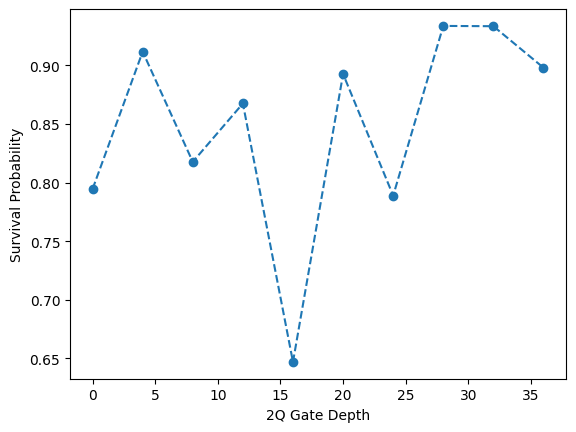

In [49]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4*max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel('2Q Gate Depth')
plt.ylabel('Survival Probability')
plt.show()

## Estimator

In [52]:
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

new_rx_angle = Parameter('rx_angle')
new_numb_trotter_steps = 2
qc = generate_1d_tfim_circuit(num_of_qubits, rx_angle=new_rx_angle, numb_trotter_steps=new_numb_trotter_steps)
middle_index = num_of_qubits//2
observable = SparsePauliOp("I"*middle_index+"Z"+"I"*(middle_index-1))

In [54]:
qc_transpiled = transpile(qc, backend=backend, optimization_level=1)
observable = observable.apply_layout(qc_transpiled.layout)

In [56]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2
num_rx_angle = 12
rx_angle_list = np.linspace(min_rx_angle, max_rx_angle, num_rx_angle)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(mode=backend, options=options)

est_job = estimator.run([(qc_transpiled, observable, rx_angle_list)])
print(est_job.job_id())

cxs9s9dwk6yg008hst3g


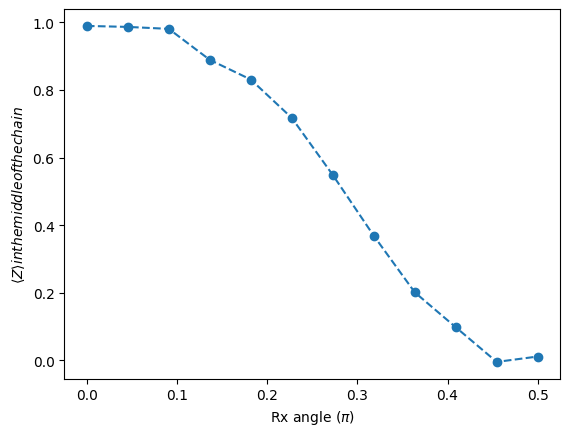

In [57]:
new_est_job = service.job(f"{est_job.job_id()}")
exp_val_list = new_est_job.result()[0].data.evs

plt.plot(rx_angle_list/np.pi, exp_val_list, '--o')
plt.xlabel(r'Rx angle ($\pi$)')
plt.ylabel(r'$\langle Z \rangle in the middle of the chain$')
plt.show()